<a href="https://colab.research.google.com/github/abraham-john-paul/AppliedAICourse/blob/main/Assignment_4_Instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

# del X_train,X_test

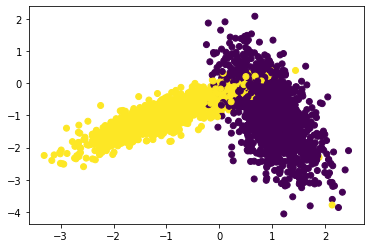

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import random
import warnings
warnings.filterwarnings("ignore")

100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

24


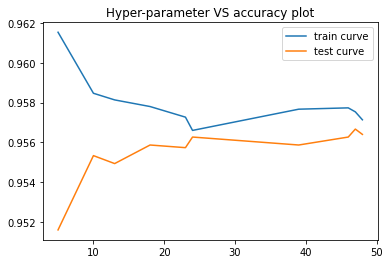

In [54]:
def generateFoldIndices(n, folds):
    if isinstance(n, (int,)) and isinstance(folds, (int,)):
        if n < 1 or n < folds:
            return list()
        indices = list(range(n))
        # Generating random shuffle of no.s from '0' to 'n - 1'
        random.shuffle(indices)
        # Finding no. of elements in one fold in K-fold
        fold_size = n // folds
        fold_indices = []
        for i in range(0, n, fold_size):
            if n - (i + fold_size) >= fold_size:
                fold_indices.append(indices[i:i + fold_size])
            else:
                fold_indices.append(indices[i:])
                break
        return indices, fold_indices
    else:
        print("enter a list size greater than 0")

def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    ''' x_train: its numpy array of shape, (n,d)
        y_train: its numpy array of shape, (n,) or (n,1)
        classifier: its typically KNeighborsClassifier()
        param_range: its a tuple like (a,b) a < b
        folds: an integer, represents number of folds we need to devide the data and test our model
    '''
    trainscores = []
    testscores  = []
    best_k = param_range[0]
    min_diff = 1
    max_test_score_with_min_diff = 0
    # Generating 10 random k values from the param_range provided
    params = sorted(numpy.random.randint(param_range[0], param_range[1], 10))
    n_x_train = len(x_train)
    indices, fold_indices = generateFoldIndices(n_x_train, folds)
    for k in tqdm(params):
        trainscores_folds = []
        testscores_folds  = []
        for cv_list_indices in fold_indices:
            train_list_indices = list(set(indices) - set(cv_list_indices))
            # selecting the data points based on the train_indices and test_indices
            X_train = x_train[train_list_indices]
            Y_train = y_train[train_list_indices]
            X_test  = x_train[cv_list_indices]
            Y_test  = y_train[cv_list_indices]

            classifier.n_neighbors = k
            classifier.fit(X_train,Y_train)

            Y_predicted = classifier.predict(X_test)
            testscores_folds.append(accuracy_score(Y_test, Y_predicted))

            Y_predicted = classifier.predict(X_train)
            trainscores_folds.append(accuracy_score(Y_train, Y_predicted))
        mean_train_score = np.mean(np.array(trainscores_folds))
        mean_test_score = np.mean(np.array(testscores_folds))
        if abs(mean_train_score - mean_test_score) <= min_diff and mean_test_score >= max_test_score_with_min_diff:
            best_k = k
            min_diff = abs(mean_train_score - mean_test_score)
            max_test_score_with_min_diff = mean_test_score 
        trainscores.append(mean_train_score)
        testscores.append(mean_test_score)
    return trainscores, testscores, params, best_k

kNN_Classifier = KNeighborsClassifier()
param_range = (1, 50)
folds = 3

trainscores,testscores, params, k = RandomSearchCV(X_train,y_train, kNN_Classifier, param_range, folds)
print(k)
plt.plot(params, trainscores, label='train curve')
plt.plot(params, testscores, label='test curve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()